In [1]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib ipympl

/home/dianloo/Desktop/tesi/quilt


In [2]:
from quilt.interface.spiking import set_verbosity
set_verbosity(1)

T = 800 # simulate for 800 ms
dt = 0.1 # ms
points_per_bin = 10      # bins 1 ms wide
sampling_frequency = 1e3 # 1 kHz sampling frequency
burn_in_millis = 300    # the first part of the record to discard (ms)

In [3]:
from quilt.builder import NeuronCatalogue, SpikingNetwork
catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")

sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

# Magic super clean params: {'poisson_rescale': 1.9739110331634744, 'weight_rescale': 1.7952043585344422}

sn.rescale_populations(1)
sn.rescale_connectivity(1)
sn.rescale_weights(1.79)
sn.rescale_delays(1)

poisson_rescale = 1.97

sn.build()

Output()

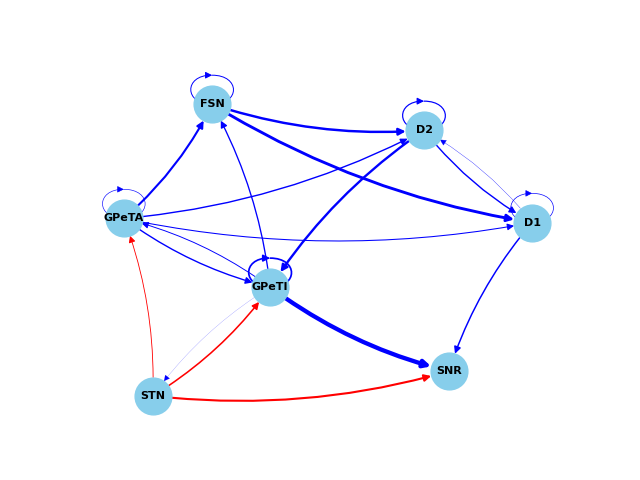

In [4]:
from quilt.view import plot_graph
fig, ax = plt.subplots()
plot_graph(sn)
plt.show()

## Input/Output

In [5]:
# pop_state_monitorized = "FSN"
for population in sn.populations.values():
    population.monitorize_spikes()
# sn.populations[pop_state_monitorized].monitorize_states()

In [6]:
poisson_inputs = dict(STN   = [500, 0.25],
                      GPeTA = [170, 0.15],
                      GPeTI = [1530, 0.25 ],
                      FSN   = [944.4, 0.5],
                      SNR   = [600, 0.55]
                    )

for pi in poisson_inputs.values():
    pi[1] *= poisson_rescale
    
for pop in poisson_inputs:
    sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])

sn.populations["D1"].add_poisson_spike_injector(1120, 0.45 * poisson_rescale)
sn.populations["D2"].add_poisson_spike_injector(972.927, 0.45 * poisson_rescale) 

## Run and get spikes

In [7]:
sn.run(dt=dt, time=T)

Running network consisting of 14622 neurons for 8000 timesteps
--------------------------------------------------
**************************************************
Simulation took 13 s	(1.69425 ms/step)
	Gathering time avg: 0.214625 us/step
	Inject time avg: 141.648 us/step
Population evolution stats:
	0:
		evolution:	456.84 us/step	---	76 ns/step/neuron
		spike emission:	40.3536 us/step	---	6 ns/step/neuron
	1:
		evolution:	433.536 us/step	---	72 ns/step/neuron
		spike emission:	89.705 us/step	---	14 ns/step/neuron
	2:
		evolution:	86.9091 us/step	---	206 ns/step/neuron
		spike emission:	31.9594 us/step	---	76 ns/step/neuron
	3:
		evolution:	113.261 us/step	---	145 ns/step/neuron
		spike emission:	27.9058 us/step	---	35 ns/step/neuron
	4:
		evolution:	65.2908 us/step	---	251 ns/step/neuron
		spike emission:	6.58675 us/step	---	25 ns/step/neuron
	5:
		evolution:	75.1276 us/step	---	184 ns/step/neuron
		spike emission:	6.4875 us/step	---	15 ns/step/neuron
	6:
		evolution:	105.594 us/st

In [8]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']

In [9]:
def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

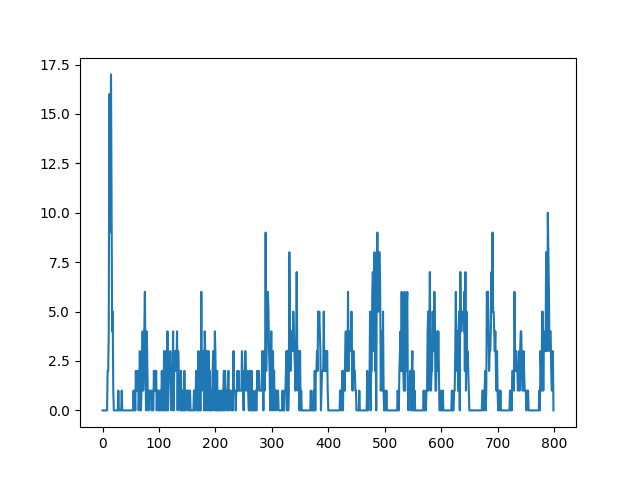

In [10]:
fig,ax = plt.subplots()
plt.plot(bin_spikes(spikes["D1"]))
plt.show()

In [11]:
from scipy.signal import welch

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data()['spikes']
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = (T - burn_in_millis)/2, # Takes at least 3 windows
                   noverlap= (T - burn_in_millis)/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    
    beta_mask = (f>12)&(f<30)
    del sn
    return np.trapz(PSD[beta_mask], x=f[beta_mask])
beta_power(sn, "GPeTA")

16.185982923950892

In [12]:
del sn

## Tuning
Starts an optuna study to tune `poisson_rescale` and `weight_rescale`. As objective function the total beta-range power is chosen.

In [13]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def build_network(poisson_rescale, rescale_weights):
    
    catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")
    sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

    sn.rescale_populations(1)
    sn.rescale_connectivity(1)
    sn.rescale_weights(rescale_weights)
    sn.rescale_delays(1)
    
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [600, 0.55],
                          D1    = [1120, 0.45],
                          D2    = [972.972, 0.45]
                        )
    # poisson_rescale = 0.8
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    
    return sn
    
def optimize_beta_power(trial):
    sn = build_network(trial.suggest_float("poisson_rescale", 0.1 , 2 ),
                       trial.suggest_float("weight_rescale", 0.1, 2))
    sn.run(dt=0.1, time=T)
    return beta_power(sn, "GPeTA")

In [14]:
set_verbosity(0) # Turns off C++ outputs

study_power = optuna.create_study(direction = 'maximize')
study_power.optimize(optimize_beta_power, n_trials = 50, n_jobs = 1, catch=(ValueError, TypeError))

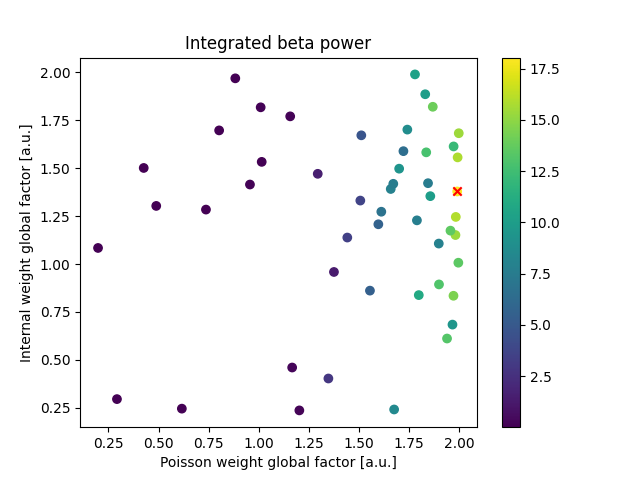

In [16]:
x = []
y = []
z = []
for trial in study_power.trials:
    x += [trial.params['poisson_rescale']]
    y += [trial.params['weight_rescale']]
    z += [trial.value]

fig, ax = plt.subplots()
plt.scatter(x, y, c=z)
plt.colorbar()
plt.scatter(study_power.best_params['poisson_rescale'],study_power.best_params['weight_rescale'], marker="x", color="r")
plt.xlabel("Poisson weight global factor [a.u.]")
plt.ylabel("Internal weight global factor [a.u.]")
plt.title("Integrated beta power")

plt.show()

## Plot best params

In [17]:
set_verbosity(1)
best_params = study_power.best_params

print(best_params)
print(study_power.best_value)

sn = build_network(best_params['poisson_rescale'], best_params['weight_rescale'])
sn.run(dt=0.1, time=8000)

{'poisson_rescale': 1.9900210317484675, 'weight_rescale': 1.3784371598232141}
18.039681331314345
Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 148 s	(1.85536 ms/step)
	Gathering time avg: 0.06825 us/step
	Inject time avg: 162.44 us/step
Population evolution stats:
	0:
		evolution:	510.173 us/step	---	85 ns/step/neuron
		spike emission:	49.145 us/step	---	8 ns/step/neuron
	1:
		evolution:	463.026 us/step	---	77 ns/step/neuron
		spike emission:	113.845 us/step	---	18 ns/step/neuron
	2:
		evolution:	90.1803 us/step	---	214 ns/step/neuron
		spike emission:	38.5116 us/step	---	91 ns/step/neuron
	3:
		evolution:	115.99 us/step	---	148 ns/step/neuron
		spike emission:	30.0774 us/step	---	38 ns/step/neuron
	4:
		evolution:	65.2502 us/step	---	250 ns/step/neuron
		spike emission:	8.91296 us/step	---	34 ns/step/neuron
	5:
		evolution:	76.304 us/step	---	187 ns/s

Mean fire rate D1 is 2.1 Hz
Mean fire rate D2 is 21.2 Hz
Mean fire rate FSN is 22.5 Hz
Mean fire rate GPeTI is 72.6 Hz
Mean fire rate GPeTA is 3.9 Hz
Mean fire rate STN is 9.9 Hz
Mean fire rate SNR is 5.8 Hz
F resolution 0.50 Hz


(0.0, 150.0)

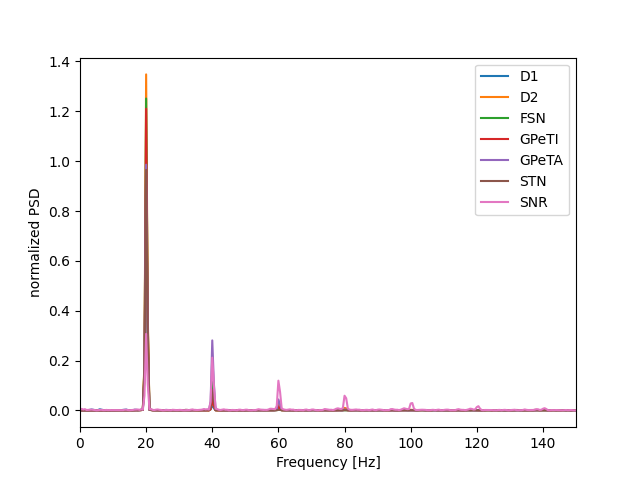

In [18]:
from scipy.integrate import simpson

timesteps_per_bin = 10
sampling_frequency = 1e4/timesteps_per_bin
fig, ax = plt.subplots()

binned_spikes = dict()
for pop in sn.populations:
    spikes = sn.populations[pop].get_data()['spikes']
    binned_spikes[pop] = bin_spikes(spikes)
    binned_spikes[pop] = binned_spikes[pop][200:]
    print(f"Mean fire rate {pop} is {np.mean(binned_spikes[pop]) :.1f} Hz")
    f, PSD = welch(binned_spikes[pop], 
                   1000, 
                   nperseg=2000, 
                   noverlap=500,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')

    norm = simpson(PSD, x=f)
    plt.plot(f, PSD/norm, label=pop)
print(f"F resolution { f[1] - f[0] :.2f} Hz")
# plt.yscale('log')
plt.legend()
plt.ylabel("normalized PSD")
plt.xlabel("Frequency [Hz]")
plt.xlim(0,150)

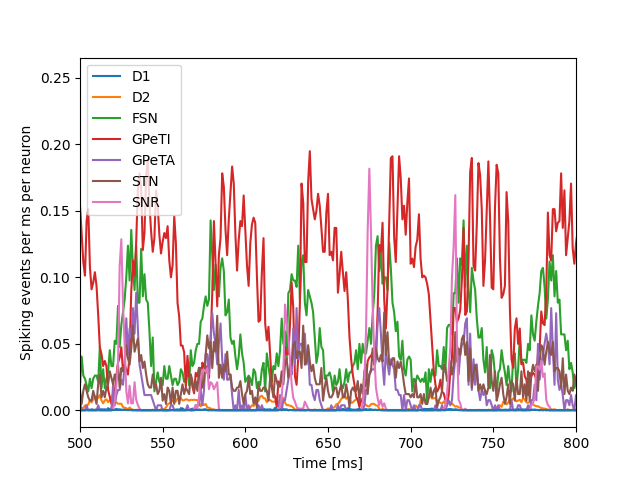

In [19]:
fig,ax = plt.subplots()
for pop in sn.populations:
    plt.plot(binned_spikes[pop]/sn.populations[pop].n_neurons, label=pop)
plt.axhline()
plt.xlabel("Time [ms]")
plt.ylabel("Spiking events per ms per neuron")
plt.xlim(500, 800)
plt.legend();

## Time signal analysis

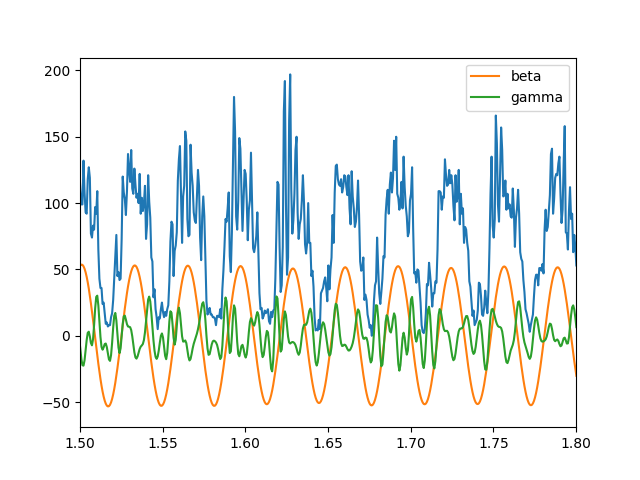

In [20]:
from scipy.signal import butter, sosfiltfilt, freqz


def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data
    
fig, ax = plt.subplots()

pop = "GPeTI"

tt = np.linspace(0, 5, len(binned_spikes[pop]))

plt.plot(tt,binned_spikes[pop])
plt.plot(tt, bandpass(binned_spikes[pop], [12, 24], 1000), label="beta")
plt.plot(tt, bandpass(binned_spikes[pop], [30, 140], 1000), label="gamma")
plt.xlim(1.50, 1.80)
plt.legend()

## Spectral entropy

In [21]:
from scipy.stats import entropy

def build_network(D1_freq = 1120, D2_freq = 972.972):
    catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")
    sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

    sn.rescale_populations(1)
    sn.rescale_connectivity(1)
    sn.rescale_weights(1.17)
    sn.rescale_delays(1)
    
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [600, 0.55],
                          D1    = [D1_freq, 0.45],
                          D2    = [D2_freq, 0.45]
                        )
    
    poisson_rescale = 1.85
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    return sn

def spectral_entropy(sn, population):    
    spikes = sn.populations[population].get_data()['spikes']
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = (T - burn_in_millis)/2, # Takes at least 3 windows
                   noverlap= (T - burn_in_millis)/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    
    psd_normalized = PSD / np.trapz(PSD, x=f)
    spectral_entropy_value = entropy(psd_normalized, base=2)

    return spectral_entropy_value

def optimize_spectral_entropy(trial):
    sn = build_network(trial.suggest_float("D1_freq", 800 , 1200 ),
                       trial.suggest_float("D2_freq", 800, 1200))    
    sn.run(dt=0.1, time=T)
    return spectral_entropy(sn, "D1")

In [31]:
set_verbosity(0) 

study_entropy = optuna.create_study(direction = 'minimize')
study_entropy.optimize(optimize_spectral_entropy, n_trials = 100, n_jobs = 1, catch=(ValueError, TypeError))

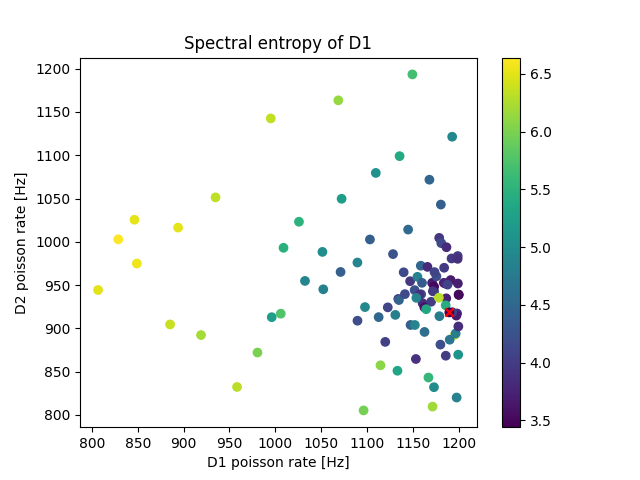

In [32]:
x = []
y = []
z = []
for trial in study_entropy.trials:
    x += [trial.params['D1_freq']]
    y += [trial.params['D2_freq']]
    z += [trial.value]

fig, ax = plt.subplots()

plt.scatter(x, y, c=z)
plt.colorbar()
plt.scatter(study_entropy.best_params['D1_freq'],study_entropy.best_params['D2_freq'], marker="x", color="r")

plt.xlabel("D1 poisson rate [Hz]")
plt.ylabel("D2 poisson rate [Hz]")
plt.title("Spectral entropy of D1")
plt.show()

In [33]:
set_verbosity(1)
best_params = study_entropy.best_params

print(best_params)
print(study_entropy.best_value)

# sn = build_network(**best_params)
sn = build_network(D1_freq=best_params['D1_freq'], D2_freq=best_params['D2_freq'])
sn.run(dt=0.1, time=1000)

{'D1_freq': 1189.5869518338486, 'D2_freq': 918.4293662114698}
3.4404949896268833
Running network consisting of 14622 neurons for 10000 timesteps
--------------------------------------------------
**************************************************
Simulation took 16 s	(1.6886 ms/step)
	Gathering time avg: 0.0402 us/step
	Inject time avg: 154.24 us/step
Population evolution stats:
	0:
		evolution:	483.534 us/step	---	80 ns/step/neuron
		spike emission:	57.4199 us/step	---	9 ns/step/neuron
	1:
		evolution:	409.47 us/step	---	68 ns/step/neuron
		spike emission:	79.0904 us/step	---	13 ns/step/neuron
	2:
		evolution:	80.4968 us/step	---	191 ns/step/neuron
		spike emission:	31.1401 us/step	---	74 ns/step/neuron
	3:
		evolution:	107.008 us/step	---	137 ns/step/neuron
		spike emission:	29.1755 us/step	---	37 ns/step/neuron
	4:
		evolution:	60.5422 us/step	---	232 ns/step/neuron
		spike emission:	5.1021 us/step	---	19 ns/step/neuron
	5:
		evolution:	71.1165 us/step	---	174 ns/step/neuron
		spike

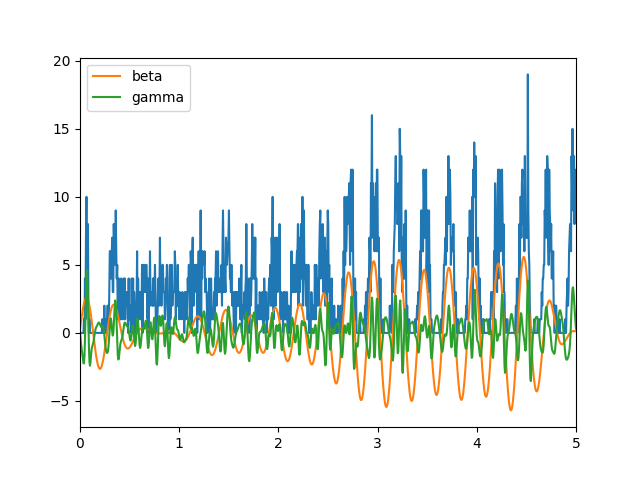

In [34]:
fig, ax = plt.subplots()

pop = "D1"
binned_spikes[pop] = bin_spikes(sn.populations[pop].get_data()['spikes'])
tt = np.linspace(0, 5, len(binned_spikes[pop]))
plt.plot(tt, binned_spikes[pop])
plt.plot(tt, bandpass(binned_spikes[pop], [12, 24], 1000), label="beta")
plt.plot(tt, bandpass(binned_spikes[pop], [30, 140], 1000), label="gamma")
plt.xlim(0, 5)
plt.legend()